In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import io
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.metrics import log_loss, auc, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import plot_roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold




import missingno
import sklearn

from imblearn.over_sampling import SMOTE
import scikitplot as skplt

from xgboost import XGBClassifier
from xgboost import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

# File located in google drive
# dataset: https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

url = "https://drive.google.com/uc?export=download&id=1l_jJ1AYLi3Qsm6wr8TChBADnTOtMnoIr"

file = requests.get(url).content
df = pd.read_csv(io.StringIO(file.decode('utf-8')))



In [2]:
# Look at the top rows in the data
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
# Understand the structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
enrollee_id               19158 non-null int64
city                      19158 non-null object
city_development_index    19158 non-null float64
gender                    14650 non-null object
relevent_experience       19158 non-null object
enrolled_university       18772 non-null object
education_level           18698 non-null object
major_discipline          16345 non-null object
experience                19093 non-null object
company_size              13220 non-null object
company_type              13018 non-null object
last_new_job              18735 non-null object
training_hours            19158 non-null int64
target                    19158 non-null float64
dtypes: float64(2), int64(2), object(10)
memory usage: 2.0+ MB


In [4]:
# Get in the list "categorical_columns" the columns that are type "object"
s = (df.dtypes == 'object')
categorical_columns = list(s[s].index)

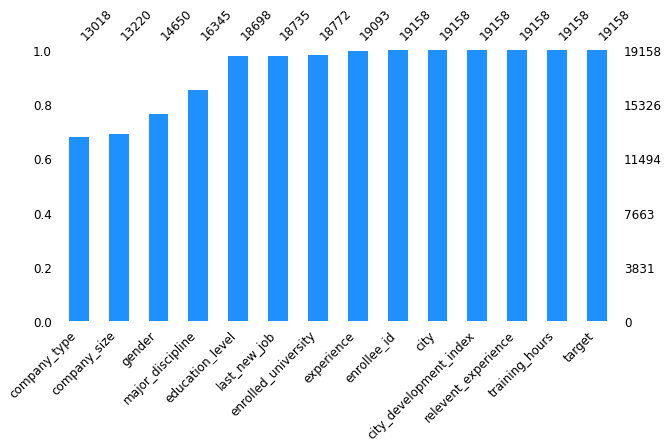

In [5]:
# Plot the columns that are missing data
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [6]:
# Look at the % of missing data for each column

for col in df.columns:
    null_val = df[col].isnull().sum()
    null_prec = (null_val * 100) / df.shape[0]
    print('> %s , Unknown: %d (%.1f%%)' % (col, null_val, null_prec))

> enrollee_id , Unknown: 0 (0.0%)
> city , Unknown: 0 (0.0%)
> city_development_index , Unknown: 0 (0.0%)
> gender , Unknown: 4508 (23.5%)
> relevent_experience , Unknown: 0 (0.0%)
> enrolled_university , Unknown: 386 (2.0%)
> education_level , Unknown: 460 (2.4%)
> major_discipline , Unknown: 2813 (14.7%)
> experience , Unknown: 65 (0.3%)
> company_size , Unknown: 5938 (31.0%)
> company_type , Unknown: 6140 (32.0%)
> last_new_job , Unknown: 423 (2.2%)
> training_hours , Unknown: 0 (0.0%)
> target , Unknown: 0 (0.0%)


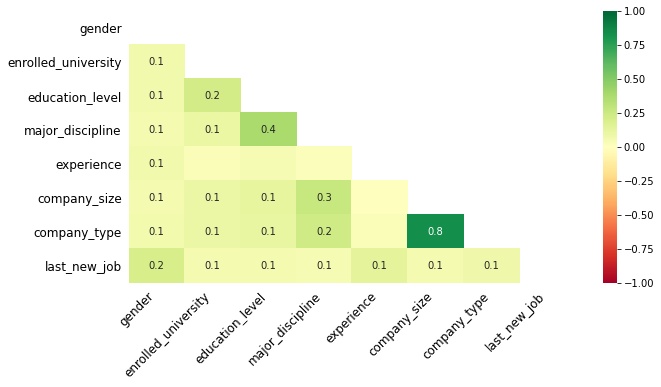

In [7]:
# Plot the heatmap of missing fields in each column
missingno.heatmap(df, cmap="RdYlGn", figsize=(10,5), fontsize=12);

In [8]:
# Add the columns that are missing data in the list "missing_cols"
missing_cols = df.columns[df.isna().any()].tolist()
missing_cols

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [9]:
# Use this step and change the variable to extract the distinct values of each column
df.experience.unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

In [10]:
# Create the mapping for each categorical column 

gender_map = {
        'Female': 2,
        'Male': 1,
        'Other': 0
         }

relevent_experience_map = {
    'Has relevent experience':  1,
    'No relevent experience':    0
}

enrolled_university_map = {
    'no_enrollment'   :  0,
    'Full time course':    1, 
    'Part time course':    2 
}
    
education_level_map = {
    'Primary School' :    0,
    'Graduate'       :    2,
    'Masters'        :    3, 
    'High School'    :    1, 
    'Phd'            :    4
    } 
    
major_discipline_map ={ 
    'STEM'                   :    0,
    'Business Degree'        :    1, 
    'Arts'                   :    2, 
    'Humanities'             :    3, 
    'No Major'               :    4, 
    'Other'                  :    5 
}
    
experience_map = {
    '<1'      :    0,     '1'       :    1,     '2'       :    2,     '3'       :    3,     '4'       :    4,     '5'       :    5,    '6'       :    6,    '7'       :    7,
    '8'       :    8,     '9'       :    9,     '10'      :    10,     '11'      :    11,    '12'      :    12,    '13'      :    13,     '14'      :    14, 
    '15'      :    15,     '16'      :    16,    '17'      :    17,    '18'      :    18,    '19'      :    19,     '20'      :    20,     '>20'     :    21
} 
    
company_type_map = {
    'Pvt Ltd'               :    0,
    'Funded Startup'        :    1, 
    'Early Stage Startup'   :    2, 
    'Other'                 :    3, 
    'Public Sector'         :    4, 
    'NGO'                   :    5
}

company_size_map = {
    '<10'          :    0,
    '10/49'        :    1, 
    '100-500'      :    2, 
    '1000-4999'    :    3, 
    '10000+'       :    4, 
    '50-99'        :    5, 
    '500-999'      :    6, 
    '5000-9999'    :    7
}
    
last_new_job_map = {
    'never'        :    0,
    '1'            :    1, 
    '2'            :    2, 
    '3'            :    3, 
    '4'            :    4, 
    '>4'           :    5
}

df['gender'] = df.gender.map(gender_map)
df['relevent_experience'] = df.relevent_experience.map(relevent_experience_map)
df['enrolled_university'] = df.enrolled_university.map(enrolled_university_map)
df['education_level'] = df.education_level.map(education_level_map)
df['major_discipline'] = df.major_discipline.map(major_discipline_map)
df['experience'] = df.experience.map(experience_map)
df['company_type'] = df.company_type.map(company_type_map)
df['company_size'] = df.company_size.map(company_size_map)
df['last_new_job'] = df.last_new_job.map(last_new_job_map)

df.loc[:,'city'] = LabelEncoder().fit_transform(df.loc[:,'city'])


In [11]:
# Look at the data to make sure all columns are numeric and it also includes empty points
df.head(30)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.0,1,0.0,2.0,0.0,21.0,NaN,NaN,1.0,36,1.0
1,29725,77,0.776,1.0,0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47,0.0
2,11561,64,0.624,NaN,0,1.0,2.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,33241,14,0.789,NaN,0,NaN,2.0,1.0,0.0,NaN,0.0,0.0,52,1.0
4,666,50,0.767,1.0,1,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8,0.0
5,21651,57,0.764,NaN,1,2.0,2.0,0.0,11.0,NaN,NaN,1.0,24,1.0
6,28806,49,0.920,1.0,1,0.0,1.0,NaN,5.0,5.0,1.0,1.0,24,0.0
7,402,83,0.762,1.0,1,0.0,2.0,0.0,13.0,0.0,0.0,5.0,18,1.0
8,27107,5,0.920,1.0,1,0.0,2.0,0.0,7.0,5.0,0.0,1.0,46,1.0
9,699,5,0.920,NaN,1,0.0,2.0,0.0,17.0,4.0,0.0,5.0,123,0.0


In [12]:
# Sepatare in two lists the columns with null values vs. those that don't have null values
df_wnulls = df[['enrollee_id']+missing_cols]
df_nonulls = df.drop(missing_cols,axis=1)

In [13]:
# Complete the empty values by using a K-Nearest-Neighbor approach to classify the missing values

knn_imputer = KNNImputer(n_neighbors = 3)

X = np.round(knn_imputer.fit_transform(df_wnulls))

df_wnulls = pd.DataFrame(X, columns = df_wnulls.columns)

df = pd.merge(df_wnulls, df_nonulls, on = 'enrollee_id')

In [14]:
# Data now does not contain nulls
df.head()

,enrollee_id,gender,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city,city_development_index,relevent_experience,training_hours,target
0,8949.0,1.0,0.0,2.0,0.0,21.0,4.0,1.0,1.0,5,0.920,1,36,1.0
1,29725.0,1.0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,77,0.776,0,47,0.0
2,11561.0,1.0,1.0,2.0,0.0,5.0,2.0,0.0,0.0,64,0.624,0,83,0.0
3,33241.0,1.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,14,0.789,0,52,1.0
4,666.0,1.0,0.0,3.0,0.0,21.0,5.0,1.0,4.0,50,0.767,1,8,0.0


In [15]:
# Check that every column does not contain nulls
for col in df.columns:
    null_val = df[col].isnull().sum()
    null_prec = (null_val * 100) / df.shape[0]
    print('> %s , Unknown: %d (%.1f%%)' % (col, null_val, null_prec))

> enrollee_id , Unknown: 0 (0.0%)
> gender , Unknown: 0 (0.0%)
> enrolled_university , Unknown: 0 (0.0%)
> education_level , Unknown: 0 (0.0%)
> major_discipline , Unknown: 0 (0.0%)
> experience , Unknown: 0 (0.0%)
> company_size , Unknown: 0 (0.0%)
> company_type , Unknown: 0 (0.0%)
> last_new_job , Unknown: 0 (0.0%)
> city , Unknown: 0 (0.0%)
> city_development_index , Unknown: 0 (0.0%)
> relevent_experience , Unknown: 0 (0.0%)
> training_hours , Unknown: 0 (0.0%)
> target , Unknown: 0 (0.0%)


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


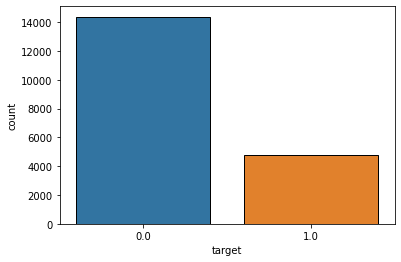

In [16]:

sns.countplot(df['target'], edgecolor = 'black')

#Convert to Code to export data in CSV format
df.to_csv('data.csv', sep=',')

In [17]:
# Prepare variables by dropping id & target for X, and just add the target to Y 
#X = df.drop(['city', 'city_development_index'], axis = 1)
X = df.drop(['enrollee_id','target'], axis = 1)
Y = df['target']

In [18]:
# Observe that all columns are now numeric
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19158 entries, 0 to 19157
Data columns (total 12 columns):
gender                    19158 non-null float64
enrolled_university       19158 non-null float64
education_level           19158 non-null float64
major_discipline          19158 non-null float64
experience                19158 non-null float64
company_size              19158 non-null float64
company_type              19158 non-null float64
last_new_job              19158 non-null float64
city                      19158 non-null int64
city_development_index    19158 non-null float64
relevent_experience       19158 non-null int64
training_hours            19158 non-null int64
dtypes: float64(9), int64(3)
memory usage: 2.5 MB


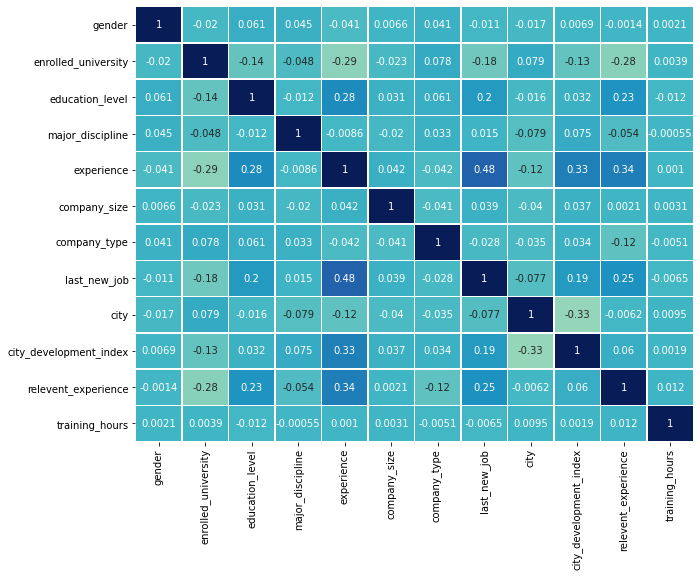

In [19]:
#Plot a correlation matrix to determine if there are any variables we need to adjust
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

# End of Data Processing

In [21]:
#Convert to Code to export data in CSV format
df.to_csv('data_clean.csv', sep=',')